In [1]:
# import all libraries

import pandas as pd
import numpy as np


# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")   

import matplotlib.pyplot as plt
import seaborn as sns

# For time stamps
from datetime import datetime

from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.


import statsmodels.graphics.tsaplots as sgt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



In [2]:
# import data

data= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')

In [3]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

In [4]:
# make close stationary using first order differencing

data['Close First Difference'] = data['Close'] - data['Close'].shift(1)

# drop the datapoint with null Value

data.dropna(inplace=True)
print(data.shape)
data.head()

(299, 7)


,id,Date,Open,Close,Volume,Strategy,Close First Difference
1,1,2015-06-08,64.116235,74.443331,227974800,Hold,-1.166647
2,2,2015-06-15,47.701942,71.140831,250670900,Buy,-3.302500
3,3,2015-06-22,54.754816,72.881344,223614300,Hold,1.740512
4,4,2015-06-29,48.031899,66.284718,406814900,Buy,-6.596626
5,5,2015-07-06,51.374399,58.494017,590857400,Buy,-7.790701


<AxesSubplot:ylabel='Density'>

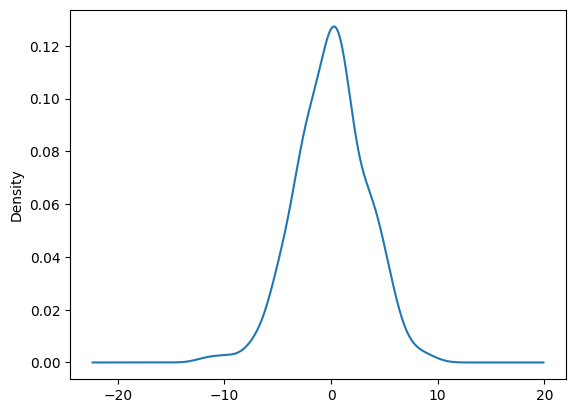

In [7]:
#Distribution of the dataset
close_price = data['Close First Difference']
close_price.plot(kind='kde')

#### SPLIT TRAIN into Train and Validation

In [16]:
# select first 0.80 of data

X_train = data.iloc[:int(data.shape[0]*0.80)]
Y_train=X_train[['Strategy','Close','Close First Difference']]

# select last 0.20 of data

X_validation = data.iloc[int(data.shape[0]*0.80):]
Y_validation=X_validation[['Strategy','Close','Close First Difference']]


In [17]:
# print shapes
print(X_train.shape)
print(X_validation.shape)

print(Y_train.shape)
print(Y_validation.shape)

(239, 7)
(60, 7)
(239, 3)
(60, 3)


# model training

In [18]:
# single exponential smoothening


df= X_train[['Close','Date']]


#### Exponential smoothening on non stationary data point

#### Single Exponential Smoothening

In [15]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

alpha_value=0.5

model1 = SimpleExpSmoothing(df['Close'])

model1_fit = model1.fit(smoothing_level=alpha_value)
forecast = model1_fit.forecast(steps=len(X_validation))


c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\util\_decorators.py:207: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [19]:
forecast.head()

239    73.065143
240    73.065143
241    73.065143
242    73.065143
243    73.065143
dtype: float64

In [20]:
# Find Error and Plot

print('Mean Squared Error:', mean_squared_error(X_validation['Close'], forecast))
print('Mean Absolute Error:', mean_absolute_error(X_validation['Close'], forecast))



Mean Squared Error: 76.53110489102022
Mean Absolute Error: 8.054474602856907


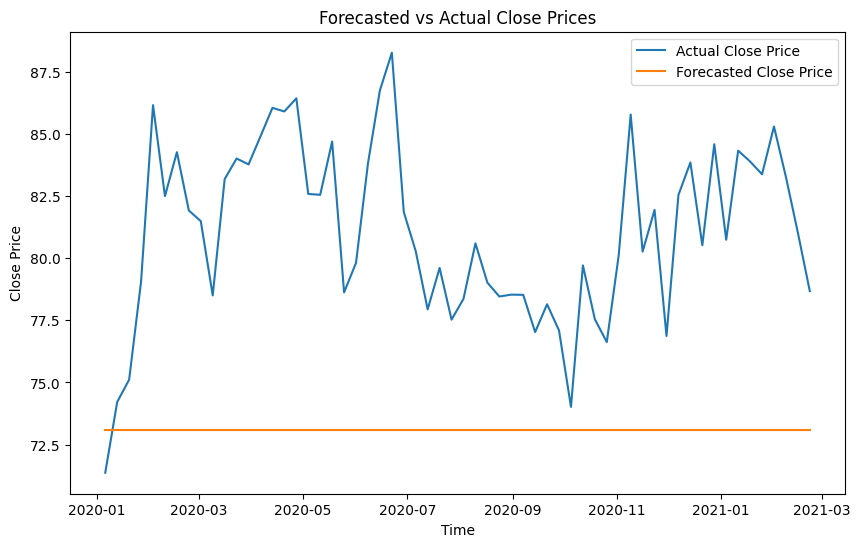

In [21]:
# plot forecasted vs actual close price

plt.figure(figsize=(10, 6))

plt.plot(X_validation['Date'], X_validation['Close'], label='Actual Close Price')
plt.plot(X_validation['Date'], forecast, label='Forecasted Close Price')
plt.title("Forecasted vs Actual Close Prices")

plt.xlabel('Time')
plt.ylabel('Close Price')

plt.legend()

plt.show()


#### Double Exponential Smoothening

In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

alpha_value = 0.9
beta_value = 0.6

model = ExponentialSmoothing(df['Close'], trend='add')
model_fit = model.fit(smoothing_level=alpha_value, smoothing_slope=beta_value)

# Generate forecasts
forecast = model_fit.forecast(steps=len(X_validation))


c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [24]:
forecast.head()

239    70.604360
240    69.622789
241    68.641217
242    67.659646
243    66.678075
dtype: float64

Mean Squared Error: 1856.9599434177496
Mean Absolute Error: 39.41496579074413


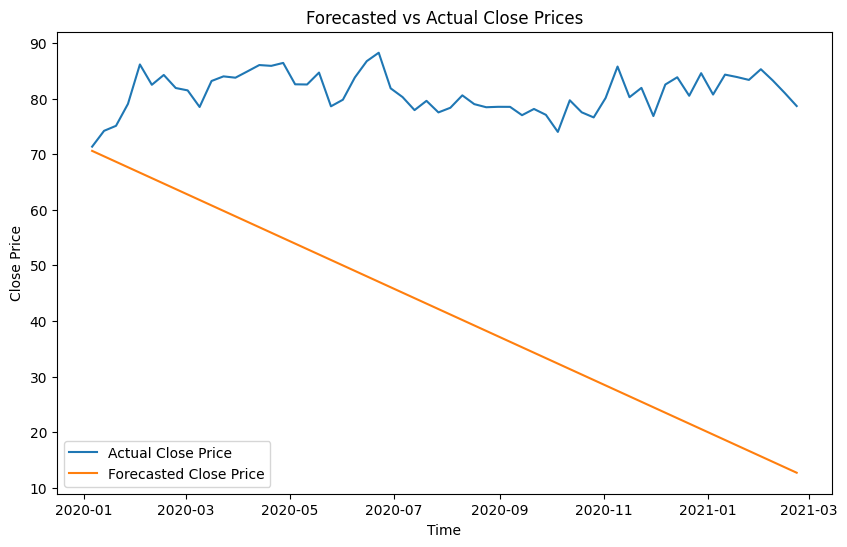

In [25]:
# Find Error and Plot

print('Mean Squared Error:', mean_squared_error(X_validation['Close'], forecast))
print('Mean Absolute Error:', mean_absolute_error(X_validation['Close'], forecast))

# plot forecasted vs actual close price

plt.figure(figsize=(10, 6))

plt.plot(X_validation['Date'], X_validation['Close'], label='Actual Close Price')
plt.plot(X_validation['Date'], forecast, label='Forecasted Close Price')
plt.title("Forecasted vs Actual Close Prices")

plt.xlabel('Time')
plt.ylabel('Close Price')

plt.legend()

plt.show()


#### Triple Exponential Smoothening


In [27]:
# triple exponential smoothening

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Specify your alpha, beta, and gamma values
alpha_value = 0.9
beta_value = 0.9
gamma_value = 0.3

# Initialize the ExponentialSmoothing model with your parameter values
model = ExponentialSmoothing(df['Close'], trend='add', 
                             seasonal='add', 
                             seasonal_periods=12, 
                             initialization_method="estimated")
model_fit = model.fit(
    # smoothing_level=alpha_value, smoothing_slope=beta_value, smoothing_seasonal=gamma_value
    )

# Generate forecasts
forecast = model_fit.forecast(steps=len(X_validation))

c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [29]:
model_fit.model.params


{'smoothing_level': 0.9014916795608573,
 'smoothing_trend': 2.2962415126758776e-08,
 'smoothing_seasonal': 2.538511689079746e-10,
 'damping_trend': nan,
 'initial_level': 72.70752314556802,
 'initial_trend': -0.010914696340173623,
 'initial_seasons': array([1.43217967, 1.49735106, 0.97139424, 1.32575865, 1.09086957,
        0.51510486, 0.72392673, 1.16316737, 1.68847394, 1.22307881,
        1.78905429, 0.65550701]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

Mean Squared Error: 115.39309401518709
Mean Absolute Error: 10.12258741460901


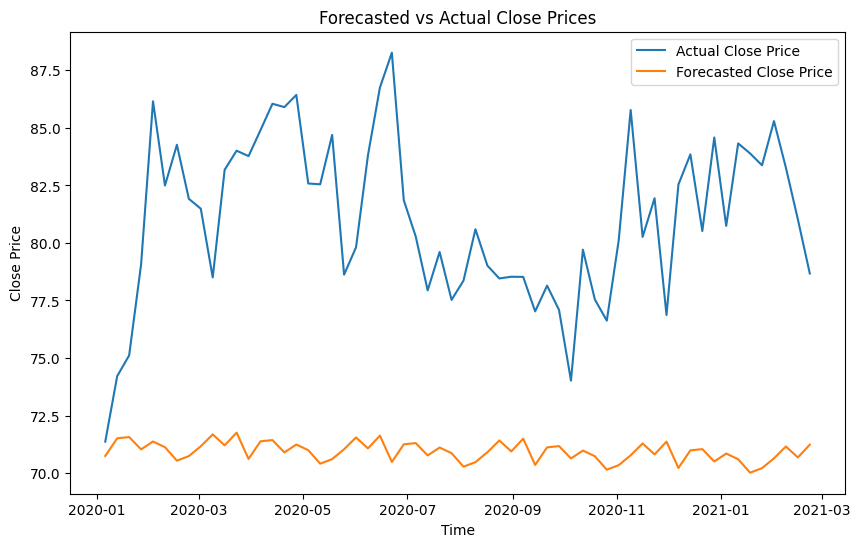

In [28]:
# Find Error and Plot

print('Mean Squared Error:', mean_squared_error(X_validation['Close'], forecast))
print('Mean Absolute Error:', mean_absolute_error(X_validation['Close'], forecast))

# plot forecasted vs actual close price

plt.figure(figsize=(10, 6))

plt.plot(X_validation['Date'], X_validation['Close'], label='Actual Close Price')
plt.plot(X_validation['Date'], forecast, label='Forecasted Close Price')
plt.title("Forecasted vs Actual Close Prices")

plt.xlabel('Time')
plt.ylabel('Close Price')

plt.legend()

plt.show()


#### Exponential smoothening on stationary data point

#### Single Exponential Smoothening